In [17]:
#!pip install pandas numpy seaborn scikit-learn keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist, cifar10
from keras.layers import Dense, Flatten, Normalization, Dropout, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, BatchNormalization, Activation, AveragePooling2D
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras import utils
try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    from keras.src.legacy.preprocessing.image import ImageDataGenerator

import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    from keras.utils import np_utils
except:
    pass
try:
    from tensorflow.keras import utils as np_utils
except:
    pass

#tf.config.list_physical_devices()

# Neural Networks and Images

Images are perhaps the place where neural networks have had the most dramatic impact. The best neural networks can very accurately perform image recognition, to the point that they can identify disease in medical imaging better than doctors, or track people's faces (or even their gait) in real time video. 

Image processing and applications such as image recognition is one of the most visible and exciting applications of neural networks. In contrast to our previous models that can perform image classification, the structure of neural networks allows them to be tailored to be very good at dealing with image data. This also tends to be true for many "analog" data types, such as audio, video, and text, which is why many of the most impressive current applications of AI, like live translation and facial recognition, use neural networks. 

## Image Data

Until now we've used simple images that only have one color, we can expand this a bit now to handle more "normal" images. We will use one of the sample ones from Keras called cifar10. 

### Color Images

Color images have a greater depth - one layer for each color. Usually this is one for red, blue, and green, or RGB. There are other color encodings, but the idea is pretty similar. Of note for us, these images are now 3 dimensional - in terms of their representation as an array. 

![RGB](images/rgb.png "RGB" )

##### Normalization in Images

One common difference in dealing with image data is the normalization process. Images, at least with the RGB encoding we are looking at, have their values encoded on a standardized scale, normally 0 to 255. Because of this, rescaling the data to 0 and 1 can be as simple as dividing by 255. Since every feature (pixel) is on the same scale, this works exactly the same as using a MinMaxScaler.

In [18]:
# Load data
# Note: the class names are taken from the documentation
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
X_train[7].shape

(32, 32, 3)

#### Image Shapes and Color

One of our images, number 7 in the dataset, has the dimensions 32x32x3. This means that it is 32 pixels wide, 32 pixels tall, and has 3 layers of color - red, green, and blue. Each image is effectively the 3 color layers stacked on top of each other to generate a full color image.

There are other ways to encode image data, or different color spaces. RGB is probably the most common, but other ones exist and may perform better in certain scenarios. The concept is the same, but the color data is broken up into different components other than red, green, and blue. For example, a lot of image processing is done in YCbCr, which is a color space that tends to be more efficient for image processing. We won't go into the details of different color encodings, if we need to deal with images that are defined in that color space, we can use a library to convert them to RGB.

### Visualizing

We can use imshow to display one image. 

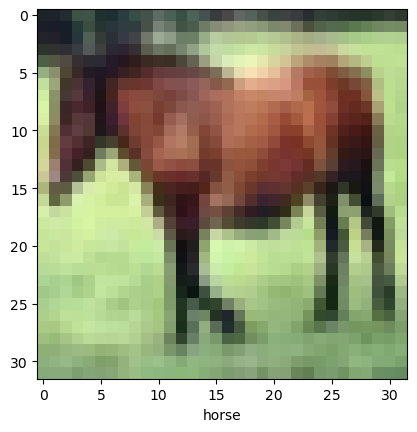

In [20]:
plt.imshow(X_train[7])
plt.xlabel(class_names[y_train[7][0]]) #The CIFAR labels happen to be arrays, so we need the extra index
plt.show()

### Helper Functions

We can make a simple helper to display an image. We can also use our loss plotting function from before. 

In [21]:
def show_img(data, labels, names, index):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[index])
    plt.xlabel(names[labels[index][0]]) #The CIFAR labels happen to be arrays, so we need the extra index
    plt.show()

# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()



Try the helper function to display an image.

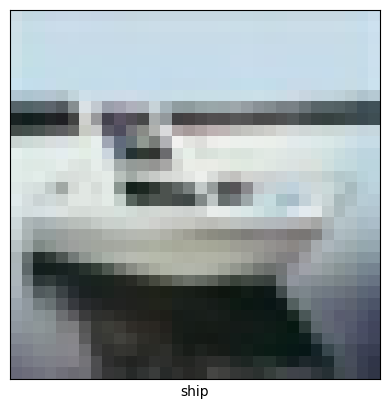

In [22]:
show_img(X_train, y_train, class_names, 192)

### Data Shape and Model

Our data starts as images that are 32 x 32 x 3 - 32 pixels by 32 pixels by color depth of 3 (RGB).

#### Flatten

One new addition we can utilize is the Flatten layer, which does exactly what is says.  The flatten layer does the same thing we did when reshaping digit images, it makes them into a flat array. We specify the shape of one example of our dataset as the input shape argument. 

### Classification - Activation and Loss

Since we are doing a classification with Keras now we need to make a few small changes to handle that. 

#### Activation

The first change is the activation on the output layer. When doing regression we want raw predictions, so there's no activation. Here we want to classify so we need to add activation. Since we are classifying into multiple classes we can use softmax to do so. We also have to set the units to the number of classes that we are predicting, in this case 10. 

Recall from when we first looked at multiclass classifications, the result of softmax is that we get a breakdown of probabilities that each record belongs to each of the classes, totalling to 1. Each class is represented by an output neuron, and the largest one wins and gets the label. 

#### Loss

We also want to use different loss metrics when doing classifications. Here we will use categorical cross entropy. 

We will need to use to_categorical here to make our current labels (e.g. [4]) into a one-hot categorical array (e.g. [0,0,0,0,1,0,0,0,0,0]). 

#### Colab Check

I've added an example here of checking if we are in Colab. For me, I'm going to increase the default epochs and shrink the defauly batch size if so. The idea here is that I can run it on a limited basis locally when developing, but then run it on Colab when I want to do a full run. If you're old and senile like me, it helps to keep you from forgetting! We could do something similar for lots of stuff, we could take a subsample of the data for developing then use it all for training, or print verbose results when developing and nothing when training, etc...

In [23]:
# Set Base Parameters
# Increase processing demands if on Colab
BASE_EPOCHS = 30
BATCH_SIZE = 512
BASE_PATIENCE = 5
MIN_DELTA = .02
MONITOR = "val_loss"
MODE = "max"

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  BASE_EPOCHS = 75
  BATCH_SIZE = 64
  BASE_PATIENCE = 10

acc = keras.metrics.CategoricalAccuracy(name="accuracy")
pre = keras.metrics.Precision(name="precision")
rec = keras.metrics.Recall(name="recall")
metric_list = [acc, pre, rec]

callback = EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, restore_best_weights=True, min_delta=MIN_DELTA, mode=MODE)

In [24]:

y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)

In [25]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               786688    
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
69/69 [==============================] - 1s 11ms/step - loss: 2.2465 - accuracy: 0.2203 - precision: 0.2657 - recall: 0.0067 - val_loss: 1.9737 - val_accuracy: 0.2941 - val_precision: 0.6322 - val_recall: 0.0212
Epoch 2/30
69/69 [==============================] - 1s 9ms/step - loss: 1.9039 - accuracy: 0.3299 - precision: 0.6437 - recall: 0.0315 - val_loss: 1.8828 - val_accuracy: 0.3335 - val_precision: 0.6245 - val_recall: 0.0573
Epoch 3/30
69/69 [==============================] - 1s 9ms/step - loss: 1.8365 - accuracy: 0.3541 - precision: 0.6373 - recall: 0.0592 - val_loss: 1.8258 - val_accuracy: 0.3548 - val_precision: 0.6161 - val_recall: 0.0660
Epoch 4/30
69/69 [==============================] - 1s 9ms/step - loss: 1.7863 - accuracy: 0.3737 - precision: 0.6514 - recall: 0.0793 - val_loss: 1.7888 - val_accuracy: 0.3691 - val_precision: 0.6615 - val_recall: 0.0819
Epoch 5/30
69/69 [==============================] - 1s 9ms/step - loss: 1.7429 - accuracy: 0.3920 - precision: 

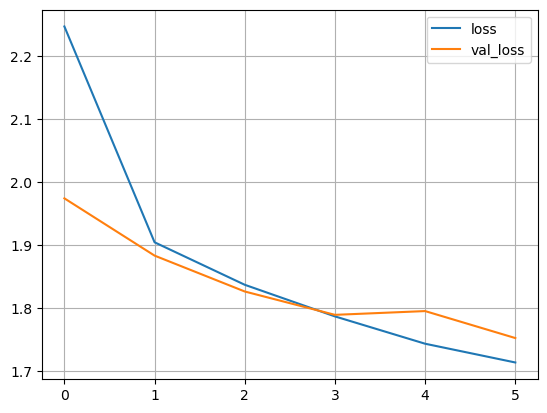

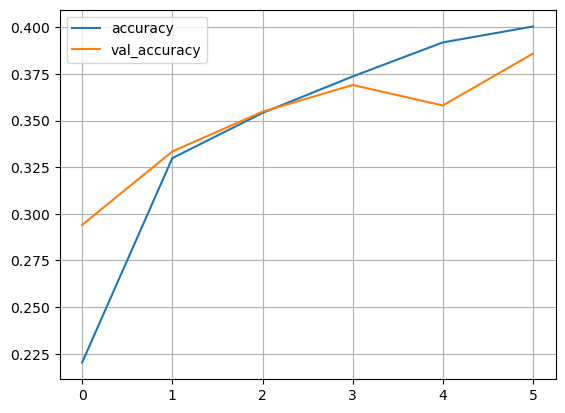

In [26]:

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

#### Baseline Accuracy: About 50% in Most Experiments

Our simple model likely didn't do all that well. We can likely do better in making predictions! If we were simpletons we'd probably look for ways to cut back that obvious overfitting. We are super sophisticated though, so we'll get all crazy and try a totally different approach...

## CNNs - Convolutional Neural Networks

To deal with images a little bit better we can use a different kind of neural network design - a CNN, or convolutional neural network. In short, a CNN is able to look at an image "as it is" caputuring spatial relationships that processing an image as a flattened array do not. When using a CNN we can first process the image in its original dimensions in the initial layers of the network, then flatten it down to go through a more familiar set of layers for the final prediction. 

A CNN looks at an image bit by bit, looking at a small square, then sliding over a few pixels, looking at another square, and so on. This has the effect of being able to extract features from areas of an image - as an example, think of an image of a bike, a CNN would be able to identify the distinct shape of a seat or handle bars as the image passes through the layers. This improves the ability of the model to identify patterns of data that define shapes in images, no matter where in the image that shape is.

### CNN Structure

A CNN has some new types of layers:
<ul>
<li> Convolutional layer - the convolutional layer looks at a small frame of the image at a time.
<li> Pooling layer - the pooling layer reduced the dimensionality of the data. 
<li> Regular neural network - after the convolutional parts to their work, we can flatten the data and pass it to a regular fully connected network at the final layers. 
</ul>

### Convolutional Layer

##### Simple Image

![CNN](images/cnn.gif "CNN")

##### More Complex Image

The convolutional layer is easiest to think of as a microscope that scrolls over an image looking at one small square of it at a time. This image is the most illustrative annimation I found of showing the convolution process; note that this one shows a stride of 2, which is why the filter seems to jump and is why the size of the output is so much smaller. We will normally rely on the pooling layer to reduce size, and use a stride of 1 with same padding to keep our outputs the same size as the inputs.  

![Kernel](images/cnn_kernel.gif "Kernel" )


This convolution operation translates the input "feature map" into an "output map". After the transformation the result is that each layer captures some features in the image - edges, orientation, etc... and map those down to lower layers. 

### Filters (a.k.a kernel) in the Convolutional Layer

One of the arguemnts we provide when making a convolutional layer is the number of filters. We have a whole bunch of filters, each learns to find some different characteristic from the image data as the training progreses. Another argument is the size of the filter. In general, filter sizes are small squares such as 3 by 3 or 5 by 5, but as images become massively higher in resolution and computers become faster, larger filters are becoming more widespread and the typical size will likely continue to increase to some degree. 

The actual values in the kernel are learned during training in a CNN, like most other things, they are determined throughout the backpropagation steps in the gradient descent process. In the context that we are typically using, image classification, the weights in the filters are learned to minimize the loss. In other words, the filters are learning to find the features that are most important to the model in order to make the best predictions. Or if we phrase it in a less nerdy way, the filters are trained to identify the parts of the image that allow it to be classified. This part is somewhat like magic, the model learns how to differentiate the different images, and it learns how to make filters that extract the key things needed to do so. 

### Padding

Padding is a setting that determines if the dimensionality of the data is reduced in the convolutional layer or not. We have two choices:

<ul>
<li> Valid padding - dimensions are reduced. 
<li> Same padding - dimensions are maintained. 
</ul>

This is probably most easily illustrated by looking at the image above. That image is showing same padding - those 0s around the border are inserted to ensure that the kernel can start at the edge and still capture the entire picture. If this were valid padding the kernel would start at the real edge, and those edge values would never make it to the middle of the image. The resulting values will then be of a smaller dimension than the original. Using same padding allows the model to better capture the information around the border, avoiding what is known as the border effect. 

In general we should expect fractionally better performance with padding enabled, at the cost of some processing time and memory. This effect isn't usually massive, as with most pictures the valuable stuff is in the middle - so the impact depends on the dataset. If you think of the minst images or something like a passport photo, the edges are usually pretty unimportant. If you think of a picture caputered by a self driving car, the edges may be the most important, to see things like curbs and kids jumping in front of the car.

#### Strides

The stride value is how many pixels the kernel window shifts each time it looks at a window. Strides of 1 move 1 pixel at a time, larger strides "skip" some pixels. Our stride will usually just be 1. 

### Pooling Layer

The pooling layer reduces the dimensionality of the data down. In image terms that you may have heard elsewhere we are downsampling - taking something that is at some higher resolution and transforming it to a lower resolution. 

This pooling step reduces the size of the data, making for more efficient calculations. It also helps generalize the ability of the model to recognize certain features. We can capture this generalization by thinking of an example - higher vs lower definition images. If we have a high definition image of something it is extremely clear, and if we have similar objects it is easy to tell them apart. For example if there are multiple cars in an image, we can probably tell them apart pretty easily - the details show the differences. If the cars are in the the background of an image (if they are in the background we are only getting a low definition version of those cars) it is harder to tell them apart - the details are different, but the general "characteristic", the fact it is a car, is consistent. Our pooling has the same impact - the pooling changes the higher definition images to lower ones, and we are better able to identify those general characteristics - making it easier to spot things that are "the same" in other images. 

The default pooling window is 2x2, so 4 features are collapsed into one. 

#### Max and Average Pooling

There are two common pooling strategies - max and average. Max pooling takes the maximum value in the pooling window as the output, average takes the average of the values in the pooling window.
<ul>
<li> Max is more common, it tends to do a better job at finding contrast - differences between light and dark, which is helpful in doing things like separating foreground and background or doing edge detection (think of navigation).
<li>Average tends to capture a more broad set of information on the entire image, with less focus on areas of distinct difference. 
</ul>

![Max_Average_Pooling](images/max_avg_pool.png "Max_Average_Pooling" )

### Normal Neural Network Layers

Once the above work is done, potentially with several layers of layers, the final layers in the network are a normal neural network. The CNN parts act to extract features from the image, the final layers take those features and produce a prediction, just as we are used to. So, loosely, the CNN classification model does some image processing in the convolutional layers to extract features and patterns from the image, we then feed the information extracted from the images into a 'normal' neural network model that makes a prediction from some features. 

### Overal Structure

After the entire model is constructed we end up with something like this. The image is translated into a series of representations - one per layer, through the convolutional process. The pooling then lowers the dimensions of those representation, and the process (potentially repeats). At the end of all the convolutional steps we feed our final represenations into the dense stages - these features are in the "shape" of an image - with the details being totally different - each layer is a filter (rather than a color) and the dimensions of the "image" are determined by the amount of pooling and padding. This is all flattened and the dense part goes on as we are used to in making predictions. 

![CNN Structure](images/cnn_structure.jpg "CNN Structure" )


#### Simple CNN

We can build a simple CNN to make some predictions on our images. In our network we'll have:
<ul>
<li> Convolutional portion:
    <ul>
    <li> Convolutional layer - 32 filters, relu activation, same padding. 
    <li> Pooling layer - (2, 2) size. Results in data 1/4 of original size.
    </ul>
<li> Dense portion:
    <ul>
    <li> Flattening of the convolutional results. 
    <li> Dense layer. 
    <li> Output layer, 10 classes, softmax prediction. 
    </ul>
</ul>

In [27]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                1048640   
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,051,082
Trainable params: 1,051,082
Non-trainable params: 0
____________________________________________

#### Create a Set of Metrics

We will define some metrics to watch, then train our model. 

Epoch 1/30
69/69 [==============================] - 7s 96ms/step - loss: 1.9900 - accuracy: 0.2882 - precision: 0.6356 - recall: 0.0208 - val_loss: 1.7754 - val_accuracy: 0.3675 - val_precision: 0.6078 - val_recall: 0.0690
Epoch 2/30
69/69 [==============================] - 6s 94ms/step - loss: 1.6462 - accuracy: 0.4245 - precision: 0.7169 - recall: 0.1109 - val_loss: 1.5648 - val_accuracy: 0.4583 - val_precision: 0.7297 - val_recall: 0.1602
Epoch 3/30
69/69 [==============================] - 6s 93ms/step - loss: 1.4722 - accuracy: 0.4848 - precision: 0.7559 - recall: 0.1964 - val_loss: 1.4617 - val_accuracy: 0.4904 - val_precision: 0.7236 - val_recall: 0.2355
Epoch 4/30
69/69 [==============================] - 7s 96ms/step - loss: 1.3579 - accuracy: 0.5272 - precision: 0.7621 - recall: 0.2620 - val_loss: 1.3885 - val_accuracy: 0.5131 - val_precision: 0.7270 - val_recall: 0.2888
Epoch 5/30
69/69 [==============================] - 6s 92ms/step - loss: 1.2812 - accuracy: 0.5534 - precisi

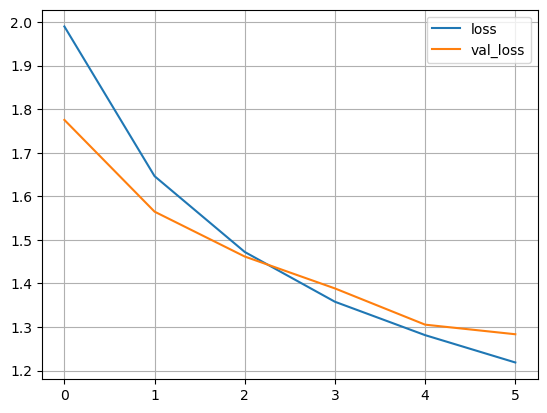

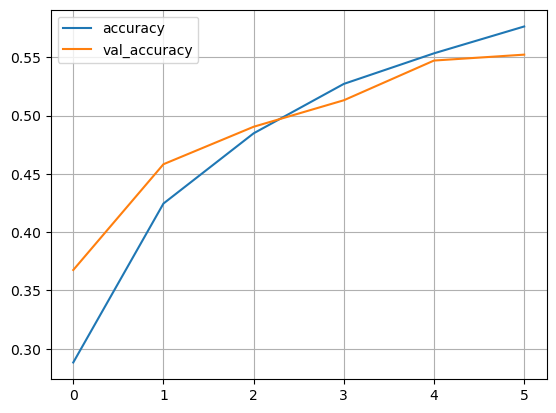

In [28]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

#### By Request - Combining Metrics and Labels

There might be a more efficient way to do this, metric._name seems like it should return the name of the metric without bothering with the inspection part. It didn't work for me, so I did it this way. I may have had a mistake that I didn't troubelshoot - reader challenge to make it better!

<b>Note:</b> the request part was from last year, this is just a note.

In [29]:
#Compile Results
import inspect
metric_list_fin =[]
for met in metric_list:
    atts = inspect.getmembers(met)
    tmp_name = [a for a in atts if(a[0] == "_name")]
    metric_list_fin.append(tmp_name[0][1])

metric_list_fin.insert(0,"loss")
metric_df = pd.DataFrame(
    {'Metrics': metric_list_fin,
     'Train': train_eval,
     'Test': test_eval
    })
metric_df.head()

/Users/akeem/anaconda3/envs/blank_tf/lib/python3.10/inspect.py:469: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  value = getattr(object, key)


,Metrics,Train,Test
0,loss,1.764002,1.770402
1,accuracy,0.371260,0.371000
2,precision,0.624756,0.611754
3,recall,0.070460,0.068700


#### Interim Results

We haven't really done all that much to tune our new model, but in the tests that I ran we were usually seeing somewhere around a 70% validation accuracy at this point - over 20% better than what we got with a non-convolutional model. This is the power of the convolutional layers - they are able to extract features from the images that are useful for making predictions in a way that a "normal" model can't. They also do this without requiring any real insight from us - we don't have to tell the model what features to look for, it figures it out on its own, so we don't have to be incredibly knowledgeable about images we are dealing with to make a good model.

<b>Note:</b> our results are likely to be a little worse than expected below due to early stopping, if we made the delta a little more permissive, we'd likely see some of the models get a little better slowly. That's what happened in inital trials, but it can take a long time to run, so we compromise. 

### CNN Trials

We'll try a few different CNN models, and see how they perform. The steps here are broadly pointing towards a more accurate model, but not super specifically. We are trying a few things here to see what we get. By the end, we'll likely have an overall more accurate model, we hope...

#### Multiple Convolutional Layers

We can try several convolutional layers, and see if that improves our results. We'll add a couple more convolutional layers, and corresponding pooling layers.

In [30]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 64)        

In [37]:
conv_layers_from_model = model.layers[0:6]

1/1 [==============================] - 0s 32ms/step
(1, 32, 32, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 4, 4, 64)


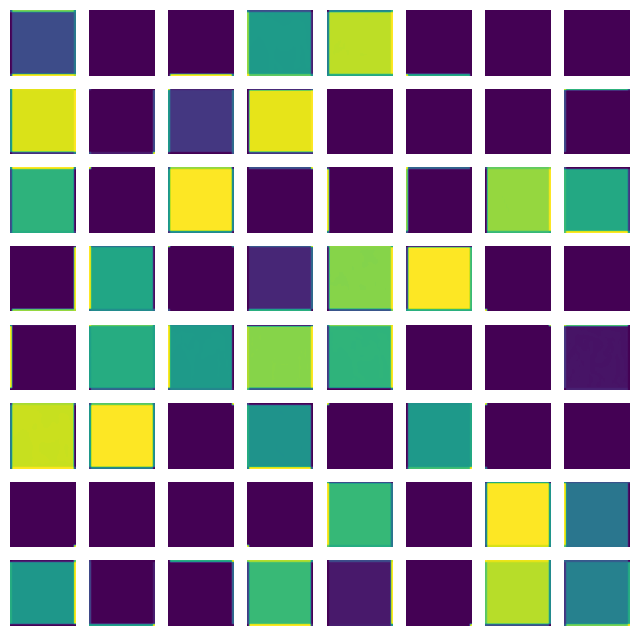

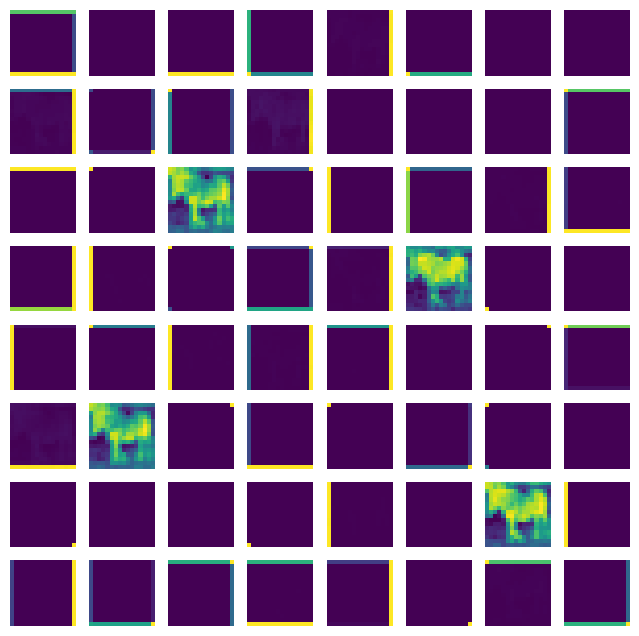

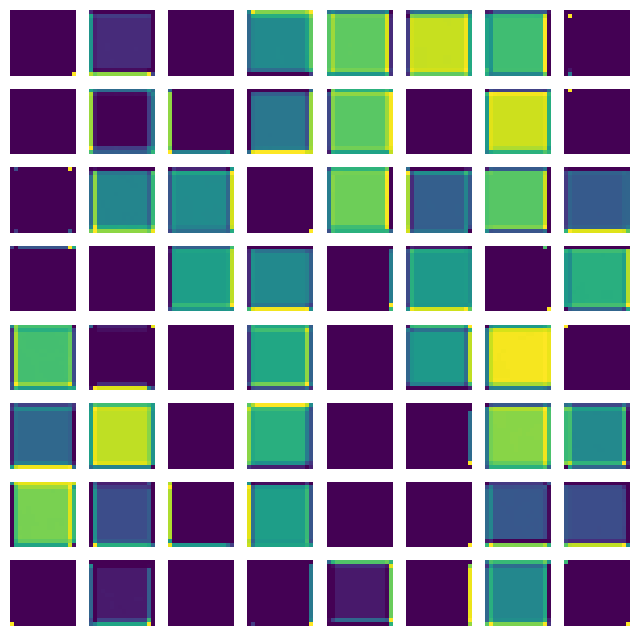

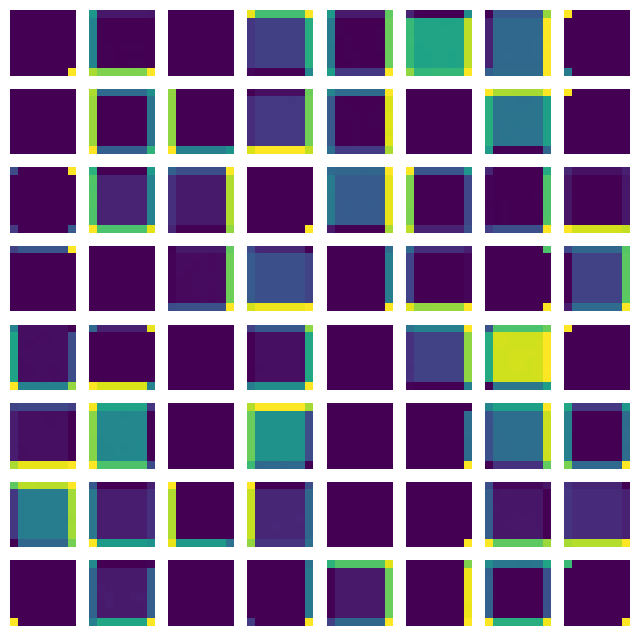

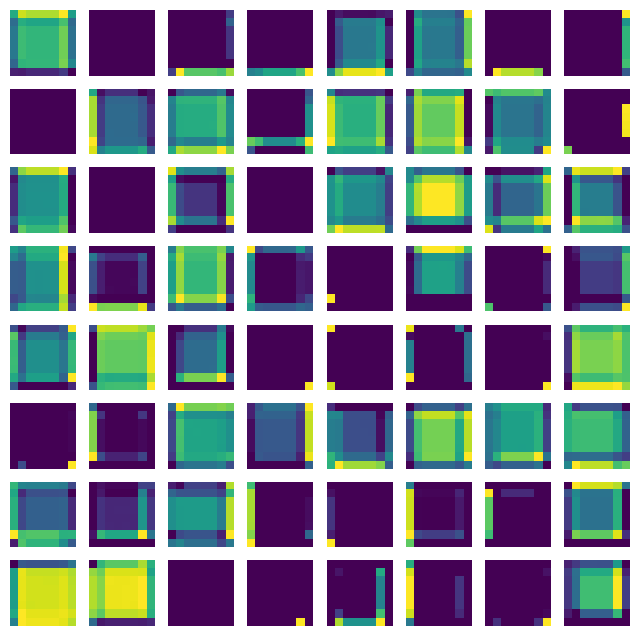

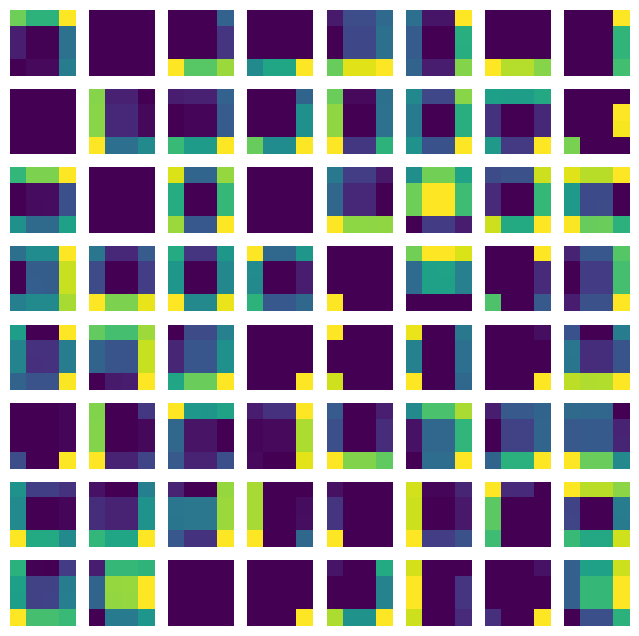

In [38]:
def visualize_image(image, layers):
    # Create a new model with the given layers
    model = tf.keras.models.Model(inputs=layers[0].input, outputs=[layer.output for layer in layers])
    
    # Preprocess the image
    preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image)
    
    # Reshape the image to match the model's input shape
    reshaped_image = tf.reshape(preprocessed_image, (1,) + preprocessed_image.shape)
    
    # Get the activations of each layer for the image
    activations = model.predict(reshaped_image)
    
    # Print the image after each layer transformation
    for layer_activation in activations:
        print(layer_activation.shape)
        # You can add code here to visualize the image after each layer transformation
        x_size = layer_activation.shape[1]
        y_size = layer_activation.shape[2]
        n_features = layer_activation.shape[3]
        rows = 8
        n_cols = n_features // rows
        filter_images = layer_activation[0]
        fig, ax = plt.subplots(rows, n_cols, figsize=(n_cols, rows))
        for image_index in range(n_features):
            row = image_index // n_cols
            col = image_index % n_cols
            ax[row, col].imshow(filter_images[:, :, image_index])#, cmap='viridis')
            ax[row, col].axis('off')

# Example usage
image = X_train[7]
layers = conv_layers_from_model
visualize_image(image, layers)


Epoch 1/30
137/137 [==============================] - 18s 127ms/step - loss: 1.8152 - accuracy: 0.3608 - precision: 0.6840 - recall: 0.0913 - val_loss: 1.5499 - val_accuracy: 0.4423 - val_precision: 0.6735 - val_recall: 0.1613
Epoch 2/30
137/137 [==============================] - 18s 131ms/step - loss: 1.4578 - accuracy: 0.4717 - precision: 0.6899 - recall: 0.2247 - val_loss: 1.3562 - val_accuracy: 0.5167 - val_precision: 0.7254 - val_recall: 0.2961
Epoch 3/30
137/137 [==============================] - 19s 141ms/step - loss: 1.2804 - accuracy: 0.5448 - precision: 0.7294 - recall: 0.3360 - val_loss: 1.2012 - val_accuracy: 0.5771 - val_precision: 0.7609 - val_recall: 0.3808
Epoch 4/30
137/137 [==============================] - 19s 139ms/step - loss: 1.1630 - accuracy: 0.5881 - precision: 0.7505 - recall: 0.4138 - val_loss: 1.1750 - val_accuracy: 0.5895 - val_precision: 0.7532 - val_recall: 0.4085
Epoch 5/30
137/137 [==============================] - 22s 164ms/step - loss: 1.0803 - accura

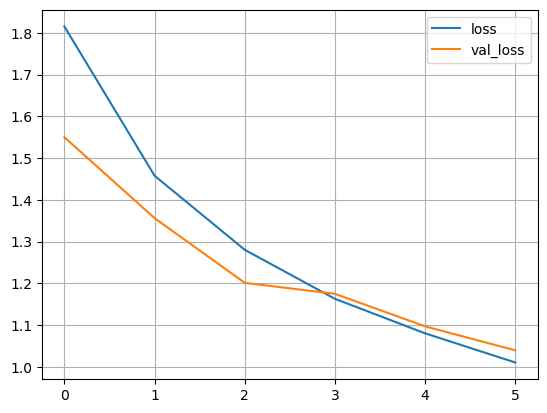

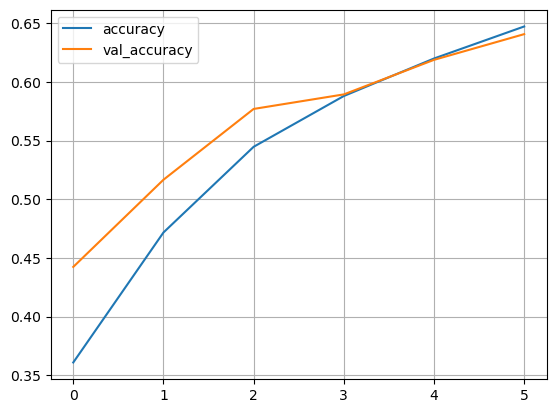

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

### CNNs - Convolutional Layers, Padding, Kernel Size

We can change the main options for our CNN without much difficulty. These changes will have impacts on our model similar to changes that we can make to any sets of hyperparameters in any models. Some changes will make minor diffrences, other large ones, and some will have no impact at all. The impact depends on the dataset that we are dealing with, and the strucutre of the model we are using. We have some intuition that we can use to guide trials, such as setting the padding depending on if the edges of our image are valuable or not, but for the most part this is trial and error land. 

#### Padding

The default padding is valid, we set ours to same up above. With padding set to same our models should do a better job of capturing information around the edges of the image. We can see what the results are when we revert it to valid. 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

Epoch 1/30
137/137 [==============================] - 18s 128ms/step - loss: 1.7881 - accuracy: 0.3719 - precision: 0.6720 - recall: 0.0911 - val_loss: 1.5996 - val_accuracy: 0.4206 - val_precision: 0.6340 - val_recall: 0.1747
Epoch 2/30
137/137 [==============================] - 17s 121ms/step - loss: 1.4371 - accuracy: 0.4885 - precision: 0.7108 - recall: 0.2311 - val_loss: 1.3592 - val_accuracy: 0.5183 - val_precision: 0.7171 - val_recall: 0.2881
Epoch 3/30
137/137 [==============================] - 16s 118ms/step - loss: 1.2817 - accuracy: 0.5519 - precision: 0.7386 - recall: 0.3316 - val_loss: 1.2783 - val_accuracy: 0.5453 - val_precision: 0.7201 - val_recall: 0.3633
Epoch 4/30
137/137 [==============================] - 16s 116ms/step - loss: 1.1991 - accuracy: 0.5787 - precision: 0.7526 - recall: 0.3869 - val_loss: 1.1944 - val_accuracy: 0.5855 - val_precision: 0.7472 - val_recall: 0.4011
Epoch 5/30
137/137 [==============================] - 16s 115ms/step - loss: 1.1254 - accura

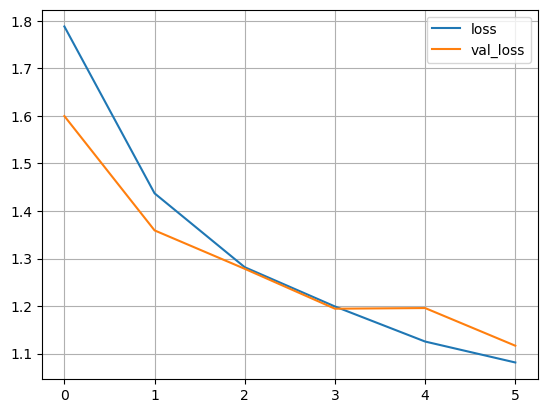

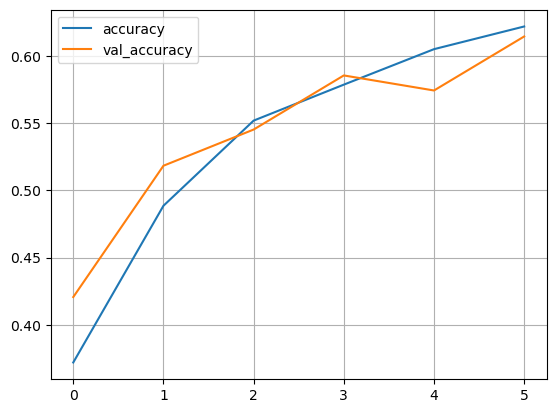

In [ ]:
# Padding
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

#### Kernel Size

We can also modify the kernel size. The kernel size is the size of the "window" - or how many pixels the filter looks at each time. 3x3 and 5x5 are probably the most common, for larger images sometimes something larger is used. The kernel size is pretty much always odd, so it is symetrical around the center pixel, this isn't a requirement, but it is a common practice.

In [ ]:
# Kernel Size
model = Sequential()
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5,5), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5,5), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        102464    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

Epoch 1/30
137/137 [==============================] - 56s 405ms/step - loss: 1.7706 - accuracy: 0.3711 - precision: 0.6457 - recall: 0.1137 - val_loss: 1.5081 - val_accuracy: 0.4542 - val_precision: 0.6650 - val_recall: 0.1841
Epoch 2/30
137/137 [==============================] - 55s 404ms/step - loss: 1.3938 - accuracy: 0.5002 - precision: 0.6995 - recall: 0.2679 - val_loss: 1.3141 - val_accuracy: 0.5317 - val_precision: 0.7056 - val_recall: 0.3347
Epoch 3/30
137/137 [==============================] - 58s 421ms/step - loss: 1.2356 - accuracy: 0.5596 - precision: 0.7378 - recall: 0.3696 - val_loss: 1.2089 - val_accuracy: 0.5751 - val_precision: 0.7343 - val_recall: 0.4004
Epoch 4/30
137/137 [==============================] - ETA: 0s - loss: 1.1277 - accuracy: 0.6041 - precision: 0.7570 - recall: 0.4361

#### Layers 

Just like with a regular neural network we can change the number of layers. In order to allow for many layers to exist despite the pooling, we will need to increase the number of filters. 

In [ ]:
# Layers
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 128)      

KeyboardInterrupt: 

In [ ]:
layers = model.layers[0:8]
visualize_image(image, layers)

#### Unpooled Convolutional Layers

We can also stack convolutional layers without pooling in between. This will allow us to capture more information, but will also increase the size of our data. We can try to double up here.

In [39]:
# Layers
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

KeyboardInterrupt: 

In [ ]:
layers = model.layers[0:8]
visualize_image(image, layers)

#### Batch Normalization

It is also relatively common to try batch normalization - or normalization layers applied between layers of a network. Batch normalization tends to have two main impacts - increase in model stability and acceleration of convergance. The reason for this is because each time data is transformed the inputs to the next layer can have their distribution shifted - something called internal covariate shift. Batch normalization adjusts this by renormalizing in the middle of each step. Note also that here we separate the dense layer and the activation - as we did with the from-scratch version. Batch normalization also can allow for faster learning rates in many cases - the improved convergance lets the algorithm go faster. 

Batch normalization is relatively new, put forth in around 2015, and the exact nature of how it improves things mathmatically is still debated (which surprised me). In particular, there is still debate on if it should be inserted between the regular layer and the activation as we have done here, or applied post activation. 

In [ ]:
# Padding
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding="same"))
model.add(BatchNormalization(epsilon=.1))
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.4))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.4))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.4))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer="l2"))
model.add(Dense(10, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[callback])
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)

### CNN Configuration Results

As we can see, the convolutional neural networks give us models that seem to be much more capable of making predictions on our images. In most of my trials, the most accurate models got to roughly 80% accuracy on the validation data, which is not bad, considering a regular model is sub 50%. Down below, after a surprise, we'll combine a bunch of these things together and see what we can get. 

<b>Note:</b> in a few trials, the batch normalization example above tended to be most impacted by setting the early stopping. If we let it run, the accuracy has seemed to improve, but slowly and with a lot of variation. 

## Directories of Images

We are going to grab some data, but this time it is not getting loaded into some data structure in our application, the file is being saved to disk and uncompressed. The end result of the code below is the same as if you were to download a file and unzip it (or in this case, un-tarball it). 

Processing images in a way similar to this is common - we may have a large number of images, and we don't want to load them all into memory at once. We can also use this approach to load images from a database, or from a remote location. The idea of loading the data into datasets is basically the same, but the details can vary a fair bit. 

In [ ]:
import pathlib
import PIL 

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
data_dir

##### Check Download by Printing One Image

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### Datasets

When dealing with things like images we commonly have actual images, not arrays or dataframes. Keras has a preprocessing function to take a folder of images and automatically create a dataset from it. A dataset is a built in datatype in tensorflow, it is kind of a specialized type of data structure that is meant to store larger volumes of generally non-tabular data, and is purpose made to be put through tensorflow networks. Here we will basically have the image files on disk be automatically loaded and split into two datasets - training and validation. When fitting the model we can use this dataset just as we would an array. 

This type of setup is fairly common when dealing with images. The particular function we used here - image_dataset_from_directory - does bulk data loading from the file structure on disk, handling all of the I/O details on its own. 

#### Dataset Components

The dataset is basically the data itself, along with some extra information on how it is to be used. For example, the data and targets are both in the dataset, the validation split is preset, as is the batch size. 

<b>Note:</b> in larger scale applications the batch size may be constrained by the memory size of the GPU. We <i>don't</i> want to load more data that can fit into memory under any circumstance, as that means that the processor will need to wait for data to be loaded to and from main memory or disk, which is very slow. For us, this isn't a pressing concern, but it is something to keep in mind.

In [ ]:
#Flowers
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

#### Build a Model with the Datasets

For the most part, things don't change significantly when using the datasets. We get to drop the arguments that are embedded in the dataset itself, like how much data to hold for validation. 

#### Example of Different Outputs

This model also has an example of an odd setup for its output. We probably don't want to do this in general, but it is worth seeing. Even though we are doing a classification, there is no activation on the output. As well, the loss function has a parameter "from logits" set to true. This is because the output is not a probability, but a raw value. This is basically offloading the softmax step to be done outside of the model's layers, because we can get output to the raw predicitons. For us, this likely won't be all that critical, it is something that you may see. One reason to do this is because in certain scenarios, the calculations may be more stable, easing convergance. Other than that edge case, we can treat it as interchangable, but probably less user friendly.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5))
model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=keras.metrics.SparseCategoricalAccuracy(name="accuracy"))
train_log = model.fit(train_ds, epochs=10, verbose=1, callbacks=[callback], validation_data=val_ds)
train_eval = model.evaluate(train_ds)
plot_loss(train_log)
plot_acc(train_log)

## Data Augmentation

When using images we can employ data augmentation to increase the size of our dataset, allowing for better training and resulting in better models. More data is king when it comes to model quality, so this is very helpful. 

The reason data augmentation is common and easy with images, where it isn't as straightforward with structured data is due to the nature of an image and what we are generally trying to do with it. Image problems are generally things like recognition - identifying what is in an image. If we are looking to identify if there is a cat in an image we probably don't  care if the cat is on the left side, the right side, rotated in any direction, tilted, etc... cats move in stupid and random ways, because they're insane lunatics, all we care about is if the cat is somewhere in there. 

![Augmented Cat](images/cat_aug.png "Augmented Cat" )

We can take advantage of this by doing all of those transformations to our images and using those transformed copies to augment our dataset! All of the mirrored, rotated, shifted, etc... images are just as good for the purposes of detecting a cat in an image, so we can use them. Free data!

In practice this is common and keras makes it quite easy. We can create a mini-network and apply some transformations, then just stick this into the top of our model. Augmentation, when it makes sense like this, has few to no downsides. We can expect a more generalizable model as if our goal is to spot cats, being able to spot them on the left, or on the right, or shifted, or rotated is an actual thing that we directly want our model to be able to do. 

Augmenting data and generating training data is something that is relatively common in many areas of machine learning - gathering and storing data can be expensive, so we want to make the most of what we have. The image examples are probably the most easy to understand, but the same idea applies to other types of data. The creation of training data is obviously something that is highly application dependent, and follows a simple idea that we've touched on a few times - as long as it helps the model predict what we need, it doesn't matter what the training data actually looks like. We've seen this in things like doing a log-transformation on income, or grouping infrequent categories into "other", the only goal is to help the model, and we can sometimes do that by distorting the data.

### Image Generators

As well, we can also introduce image generators, which can also help quite a bit in preparing our data. Image generators are a way to create a dataset from a directory of images, but with some extra functionality. We can use them to apply transformations to the images, and we can also use them to apply some preprocessing to the images. Here, we can do some augemntation. These generators are like a "smart" version of a dataset, more specifically they take in the data, potentially do some things with it, then generate the data as output on demand. Here we will ask each one to generate some images with the transformations that we setup in the generator as augmentation steps. 

One thing to note here is that I have a seemingly redundant piece of pulling data. This is because some of the augmentation functions depend on knowing the data, such as normalization, which needs to know the range of values that it is normalizing. This is why we pull some data, use it to set those parameters, then pull the data again to actually create the datasets. This is weird, and poorly designed - I thought that this really wouldn't be the correct way to do it, but it looks like this is a bug (or poor design choice) in the newest version of tensorflow. There are a lot of choices of things that we can do to augment, the tensorflow documentation has a good list of them here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator (I commented these out as it makes for more printable images if we don't use them)

<b>Big Note:</b> In my trials I got a few warning messages that were along the lines of "there is no registered converter", along with a note about a while loop. As far as I can tell this is a bug in a newer version of tensorflow (it didn't happen when I wrote this). These warnings mean that the process will be slow, but things should otherwise work. I will assume that at some point this error will be fixed. For some more info: https://stackoverflow.com/questions/73304934/

As far as I can see there are two workarounds, one is to downgrade tensorlfow, which I wouldn't reccomend on your python environment as it can be annoying, you could make another environment, your "Python_augmenting_env", and install the desired version there. The other is to basically rewrite the augmentation code, which is a bit of a pain. For us, we can try a specific import in Colab, since the environment is temporary, we don't need to worry about breaking anything else. I'm not going to put this in the code, because I don't want to cause any issues accidentally, but we can manually place it in the code if we desire. 

tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting even the Tensorflow documentation example for image classification gets hit:

![Augmentation Warning](images/augment_error.png "Augmentation Warning" )

In [ ]:
trainAugmenter = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #fill_mode='nearest',
    rotation_range=20,
    width_shift_range=0.2, 
    rescale=1./255,
    validation_split = 0.2
    )
valAugmenter = ImageDataGenerator(
    validation_split = 0.2,
    rescale=1./255
    )

# Pull Data to train the augmentation
fitAugmenter = ImageDataGenerator(
    validation_split = 0.1,
    rescale=1./255
    )
fitAug = fitAugmenter.flow_from_directory(data_dir, seed=33, subset="validation", batch_size=BATCH_SIZE, class_mode="categorical",)
trainAugmenter.fit(fitAug.next()[0])

augTrain = trainAugmenter.flow_from_directory(data_dir, seed=33, subset="training", batch_size=BATCH_SIZE, class_mode="categorical",)
augVal = valAugmenter.flow_from_directory(data_dir, seed=33, subset="validation", batch_size=BATCH_SIZE, class_mode="categorical",)


##### Preview Image

The generator generates files, on demand. In our context, we basically load the data into the generator, use the generator "as" the dataset, and the generator will generate the data, along with the augmentation, on demand when we fit the model. We can pull one image and print it to see what we get from the generator. 

In [ ]:
tmp, ytmp = augTrain.next()
for i in range(0,4):
    image = tmp[i]
    label = ytmp[i]
    print (label)
    plt.imshow(image)
    plt.show()

#### Model

Using the image generators is pretty simple. The genearators "become" the data. 

In [ ]:
model = Sequential()
#model.add(augment)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_log = model.fit(augTrain, epochs=BASE_EPOCHS, verbose=1, callbacks=[callback], validation_data=augVal)

plot_loss(train_log)
plot_acc(train_log)

## Exercise

Use the original dataset from the first section and build a model incorporating some of the CNN features. Add data augmentation, then manipulate things such as the number of layers, kernel size, padding, dropouts, etc... to try to improve accuracy. 

### My Reasoning on What to Try

In the examples above, the training accuracy generally got quite good, and in the earlier models where we didn't do as many changes, there was a large gap between testing and training accuracy. This gap lessened as we added regularization and dropouts, so that's a good sign that the model was overfitting. Out model likely has enough capacity with about 2 hidden layers. This doesn't necissarily mean that we should stop there, but we can pretty safely thing that is "enough" in terms of the capacity of the model. If we add more layers it isn't to make the model able to learn the data, we've already gotten there. We have also seen that expanding the number of filters in a convolutional layer can help, so we can add that in. As well, we can augment the data, which should help in general.

<b>Note:</b> the broken augmentation puts a bit of a damper on this one, as it is very slow to run trials. We should be able to add augemntation to one of the model configurations that got around 80% accuracy above, and see the overfit gap lessen, potentially leaving some room to allow for more fitting - either more epochs or more capacity. 

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
# Create Datasets
trainDatagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    width_shift_range=0.2,
    validation_split = 0.2
    )

valDatagen = ImageDataGenerator(
    validation_split = 0.2
    )

# We have the data, so we can fit to it. 
trainDatagen.fit(X_train)

train_generator = trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training', seed=55)
validation_generator = valDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation', seed=55)

In [ ]:
# Create Model
model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding="same", kernel_regularizer="l2"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer="l2"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.4))
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer="l2"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.4))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer="l2"))
model.add(Dense(10, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metric_list)
train_log = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs=BASE_EPOCHS, 
                      verbose=1, 
                      callbacks=[callback],
                      workers=4)
train_eval = model.evaluate(X_train, y_train)
test_eval = model.evaluate(X_test, y_test, verbose=2)
plot_loss(train_log)
plot_acc(train_log)